In [88]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from collections import defaultdict, Counter
from scipy import signal
import numpy as np
import random as rn
import cv2

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision
from torchvision import datasets, transforms

In [89]:
Data = []
Label = []

DATA_DIR = 'C:/Users/ADmin/Desktop/drum_small/'
nfolder = ['Bass', 'Bass+Hihat', 'Bass+Ride', 'Hihat', 'Snare', 'Snare+Hihat', \
           'Snare+Tom_floor', 'Tom_1', 'Tom_1+Tom_floor', 'Tom_2', 'Tom_2+Tom_floor', 'Tom_floor']


for var in range(len(nfolder)):
    for fname in os.listdir(DATA_DIR + nfolder[var]):
        img = cv2.imread(DATA_DIR + nfolder[var] + '/' + fname,cv2.IMREAD_GRAYSCALE)
        
        Data.append(img)
        Label.append(nfolder.index(nfolder[var]))

In [90]:
X_train, X_valid, y_train, y_valid = train_test_split(Data, Label, test_size = 0.2,random_state = 123, shuffle = True, stratify = Label)

In [92]:
train_X = torch.cuda.FloatTensor(X_train)
train_y = torch.cuda.LongTensor(y_train)

train_X = train_X.unsqueeze(1)

valid_X = torch.cuda.FloatTensor(X_valid)
valid_y = torch.cuda.LongTensor(y_valid)

valid_X = valid_X.unsqueeze(1)

print('train_X: ', train_X.shape)
print('train_y: ', train_y.shape)
print('----------------------------------')
print("valid_X: ", valid_X.shape)
print("valid_y: ", valid_y.shape)

train_X:  torch.Size([12544, 1, 90, 120])
train_y:  torch.Size([12544])
----------------------------------
valid_X:  torch.Size([3136, 1, 90, 120])
valid_y:  torch.Size([3136])


In [125]:
use_cuda = torch.cuda.is_available()
drop_prob = 0.1

class CNNClassifier(nn.Module):
    
    def __init__(self):
        super(CNNClassifier, self).__init__() 
        conv1 = nn.Conv2d(1, 32, 5) # 1@120*90 -> 32@116*86
        pool1 = nn.MaxPool2d(2,2) # 32@58*43
        conv2 = nn.Conv2d(32, 64, 5) # 32@58*43 -> 64@52*39
        conv2_bn = nn.BatchNorm2d(64)
        pool2 = nn.MaxPool2d(2,2) # 64@52*39 -> 64@26*19
        conv3 = nn.Conv2d(64, 128, 5) # 64@26*19 -> 128@22*15
        conv3_bn = nn.BatchNorm2d(128)
        pool3 = nn.MaxPool2d(2,2) # 128@22*15 -> 128@11*7
        
        self.conv_module = nn.Sequential(
            conv1,
            nn.ReLU(),
            pool1,
            conv2,
            conv2_bn,
            nn.ReLU(),
            pool2,
            conv3,
            conv3_bn,
            nn.ReLU(),
            pool3
        )
        
        fc1 = nn.Linear(128*11*7, 64)
        fc1_bn = nn.BatchNorm1d(64)
        fc2 = nn.Linear(64, 32)
        fc2_bn = nn.BatchNorm1d(32)
        fc3 = nn.Linear(32, 12)
        
        dropout = torch.nn.Dropout(p=drop_prob)
        
        self.fc_module = nn.Sequential(
            fc1,
            fc1_bn,
            nn.ReLU(),
            dropout,
            fc2,
            fc2_bn,
            nn.ReLU(),
            dropout,
            fc3
        )
        
    def forward(self, x):
        out = self.conv_module(x) #128*66*46
        dim = 1
        for d in out.size()[1:]:
            dim = dim * d
        out = out.view(-1, dim)
        out = self.fc_module(out)
        return F.softmax(out, dim=1)

In [126]:
from torchsummary import summary # from torch.autograd import Variable

cnn = CNNClassifier().cuda()
input_size = (1, 120, 90)
summary(cnn, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 116, 86]             832
              ReLU-2          [-1, 32, 116, 86]               0
         MaxPool2d-3           [-1, 32, 58, 43]               0
            Conv2d-4           [-1, 64, 54, 39]          51,264
       BatchNorm2d-5           [-1, 64, 54, 39]             128
              ReLU-6           [-1, 64, 54, 39]               0
         MaxPool2d-7           [-1, 64, 27, 19]               0
            Conv2d-8          [-1, 128, 23, 15]         204,928
       BatchNorm2d-9          [-1, 128, 23, 15]             256
             ReLU-10          [-1, 128, 23, 15]               0
        MaxPool2d-11           [-1, 128, 11, 7]               0
           Linear-12                   [-1, 64]         630,848
      BatchNorm1d-13                   [-1, 64]             128
             ReLU-14                   

In [127]:
train_data = TensorDataset(train_X, train_y)
train_data = DataLoader(train_data, batch_size=20, drop_last=False, shuffle=True)

valid_data = TensorDataset(valid_X, valid_y)
valid_data = DataLoader(valid_data, batch_size=4, drop_last=False, shuffle=True)

In [128]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)

num_epochs = 30
num_batches = len(train_data)

train_loss_list = []
valid_loss_list = []
train_accuracy = []
valid_accuracy = []

train_total = 0
train_correct = 0
train_incorrect = 0
valid_total = 0
valid_correct = 0
valid_incorrect = 0

for epoch in range(num_epochs):
    
    train_loss = 0.0
    for i, data in enumerate(train_data):
        x, label = data

        if use_cuda:
            x = x.cuda()
            label = label.cuda()

        optimizer.zero_grad()
        model_output = cnn(x)
        loss = criterion(model_output, label)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()/len(train_data.dataset)
        del loss
        
        for ix in range(len(model_output)):
            if torch.argmax(model_output[ix]).item() == label[ix].item():
                train_correct += 1
            else:
                train_incorrect += 1
        
        if (i+1) % num_batches == 0:
            with torch.no_grad():
                valid_loss = 0.0
                for j, valid in enumerate(valid_data):
                    valid_x, valid_label = valid
                    if use_cuda:
                        valid_x = valid_x.cuda()
                        valid_label = valid_label.cuda()
                    valid_output = cnn(valid_x)
                    v_loss = criterion(valid_output, valid_label)
                    valid_loss += v_loss/len(valid_data.dataset)
                    
                    for idx in range(len(valid_output)):
                        if torch.argmax(valid_output[idx]).item() == valid_label[idx].item():
                            valid_correct += 1
                        else:
                            valid_incorrect += 1                  

            print("epoch: {}/{} | step: {}/{} | trn loss: {:.4f} | val loss: {:.4f}".format(
                epoch+1, num_epochs, i+1, num_batches, train_loss, valid_loss
            ))            
            
            train_loss_list.append(train_loss)
            valid_loss_list.append(valid_loss)
            train_loss = 0.0
    train_accuracy.append((train_correct/(train_correct+train_incorrect))*100)
    valid_accuracy.append((valid_correct/(valid_correct+valid_incorrect))*100)

print('Accuracy of the network on the train audio: %f %%' % (train_accuracy[-1]))
print('Accuracy of the network on the test audio: %f %%' % (valid_accuracy[-1]))

epoch: 1/30 | step: 628/628 | trn loss: 0.0955 | val loss: 0.4757
epoch: 2/30 | step: 628/628 | trn loss: 0.0847 | val loss: 0.4619
epoch: 3/30 | step: 628/628 | trn loss: 0.0833 | val loss: 0.4532
epoch: 4/30 | step: 628/628 | trn loss: 0.0822 | val loss: 0.4485
epoch: 5/30 | step: 628/628 | trn loss: 0.0820 | val loss: 0.4451
epoch: 6/30 | step: 628/628 | trn loss: 0.0817 | val loss: 0.4435
epoch: 7/30 | step: 628/628 | trn loss: 0.0817 | val loss: 0.4404
epoch: 8/30 | step: 628/628 | trn loss: 0.0816 | val loss: 0.4418
epoch: 9/30 | step: 628/628 | trn loss: 0.0815 | val loss: 0.4430
epoch: 10/30 | step: 628/628 | trn loss: 0.0816 | val loss: 0.4394
epoch: 11/30 | step: 628/628 | trn loss: 0.0815 | val loss: 0.4414
epoch: 12/30 | step: 628/628 | trn loss: 0.0814 | val loss: 0.4412
epoch: 13/30 | step: 628/628 | trn loss: 0.0814 | val loss: 0.4368
epoch: 14/30 | step: 628/628 | trn loss: 0.0813 | val loss: 0.4358
epoch: 15/30 | step: 628/628 | trn loss: 0.0814 | val loss: 0.4338
epoc

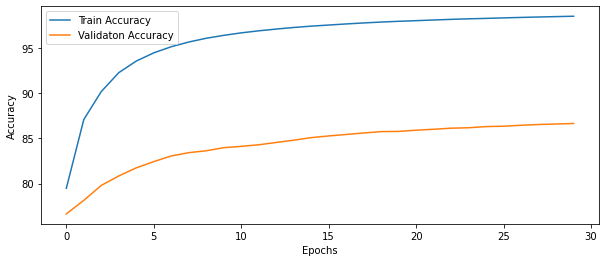

In [129]:
plt.rcParams["figure.figsize"] = (10,4)
plt.plot(train_accuracy, label = 'Train Accuracy')
plt.plot(valid_accuracy, label = 'Validaton Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()